# Weather Data Analysis
## Neural Networks


In [7]:
import pandas as pd
import numpy as np
import mlrose_hiive as mlrose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# loading the budapest dataset
df = pd.read_csv('data/weather/city_data/BUDAPEST.csv')

# dropping the date column
df = df.drop(columns=['DATE'])
# making last column the target column
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# Making true and false values to 1 and 0
y = y.map({True: 1, False: 0})

#Normalizing the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X) 

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Defining thresholds for binarization
thresholds = np.mean(X_train, axis=0)

def binarization(X, thresholds):
    X_bin = np.zeros(X.shape)
    for i in range(X.shape[1]):
        X_bin[:,i] = X[:,i] > thresholds[i]
    return X_bin

X_train_bin = binarization(X_train, thresholds)
X_test_bin = binarization(X_test, thresholds)
X_train_bin




array([[1., 1., 0., ..., 1., 1., 1.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.]])

In [94]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

nn_model = mlrose.NeuralNetwork(hidden_nodes = None, activation = 'relu',algorithm="genetic_alg",max_iters=1000, bias = True, is_classifier = True, learning_rate = 0.1, early_stopping = True, clip_max = 5, max_attempts = 200, random_state = 42,pop_size=100,mutation_prob=0.1)
nn_model.fit(X_train_bin, y_train)

y_train_pred = nn_model.predict(X_train_bin)
y_test_pred = nn_model.predict(X_test_bin)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(train_accuracy)
print(test_accuracy)


0.9332877180978447
0.9384404924760602


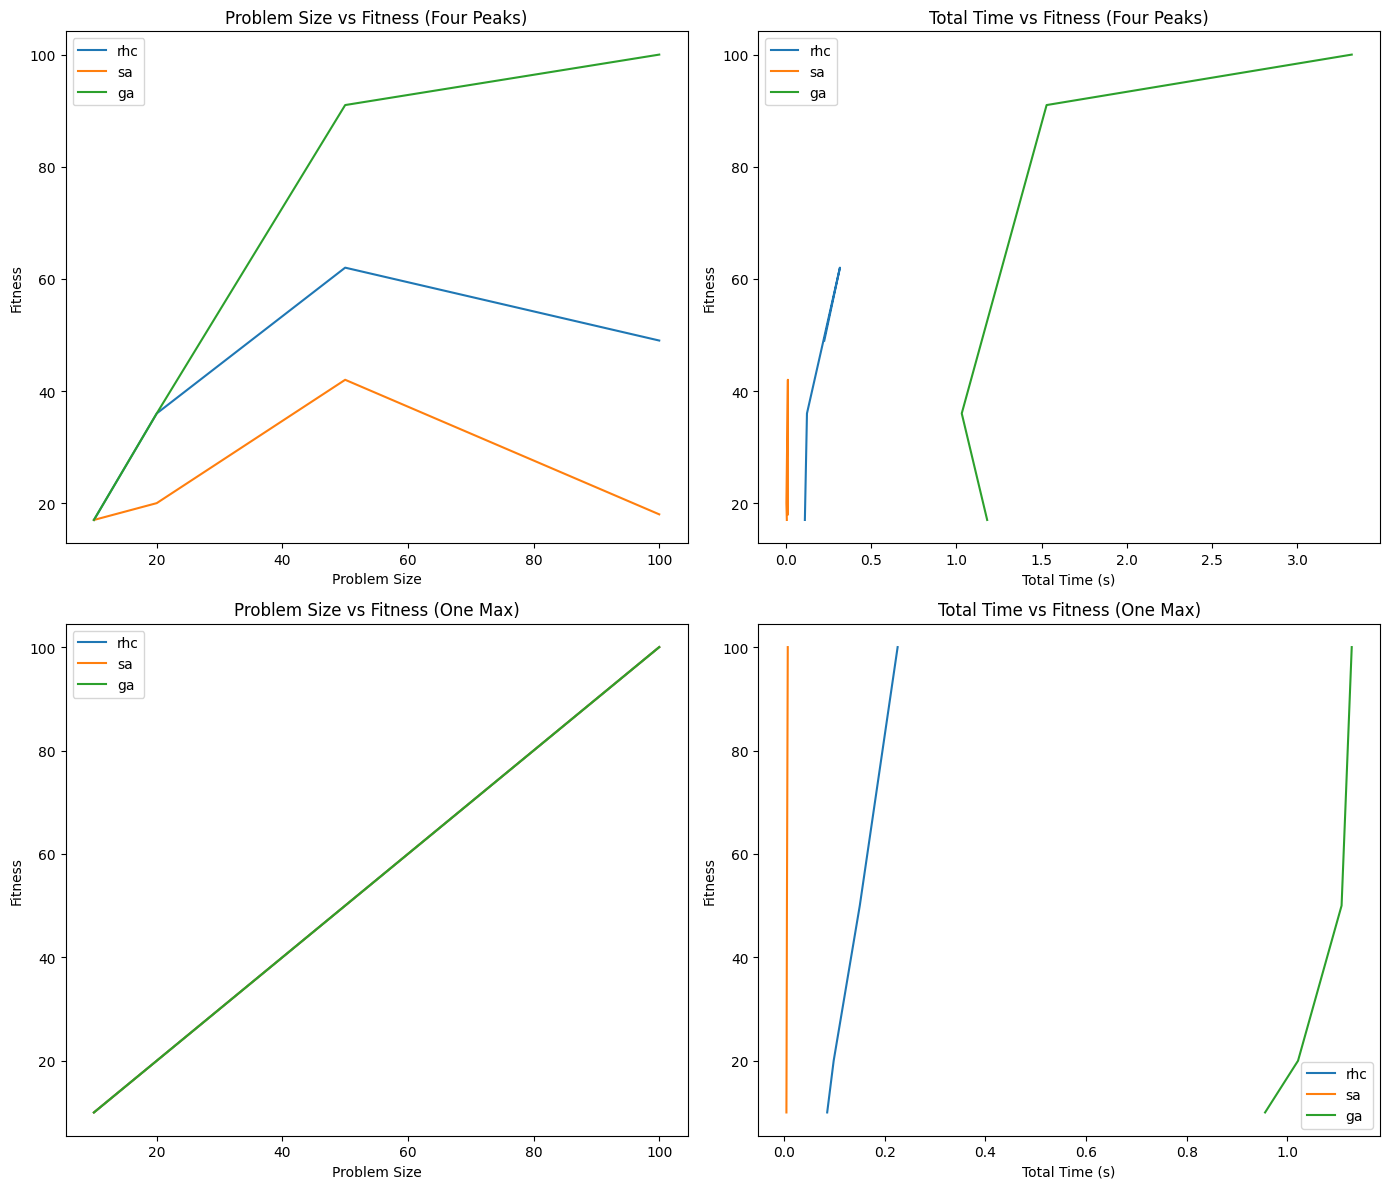

In [78]:
import numpy as np
import time
import matplotlib.pyplot as plt

# Define Four Peaks problem
problem_sizes = [10,20,50,100]
four_peaks_fitness = mlrose.FourPeaks(t_pct=0.15)# Default t_pct is 0.15
one_max_fitness = mlrose.OneMax()


# Initialize parameters
max_attempts = 200
max_iters = 1000
rhc_restarts = 50
sa_schedule = mlrose.ExpDecay()
ga_pop_size = 200
ga_mutation_prob = 0.1

# Define a function to run optimization and collect results
def run_optimization(problem, algorithm, **kwargs):
    start_time = time.time()
    if algorithm == 'rhc':
        best_state, best_fitness, fitness_curve = mlrose.random_hill_climb(problem, max_attempts=max_attempts, max_iters=max_iters, restarts=rhc_restarts, random_state=42, curve=True)
    elif algorithm == 'sa':
        best_state, best_fitness, fitness_curve = mlrose.simulated_annealing(problem, schedule=sa_schedule, max_attempts=max_attempts, max_iters=max_iters, random_state=42, curve=True)
    elif algorithm == 'ga':
        best_state, best_fitness, fitness_curve = mlrose.genetic_alg(problem, pop_size=ga_pop_size, mutation_prob=ga_mutation_prob, max_attempts=max_attempts, max_iters=max_iters, random_state=42, curve=True)
    end_time = time.time()
    return best_fitness, end_time - start_time

# Run optimization for different algorithms and problems
algorithms = ['rhc', 'sa', 'ga']
problems = {'Four Peaks': four_peaks_fitness, 'One Max': one_max_fitness}
# results = {problem_name: {algo: [] for algo in algorithms} for problem_name in problems.keys()}
results = {'Four Peaks': {algo: [] for algo in algorithms}, 'One Max': {algo: [] for algo in algorithms}}


for size in problem_sizes:
    problem = mlrose.DiscreteOpt(length=size, fitness_fn=four_peaks_fitness, maximize=True, max_val=2)
    for algo in algorithms:
        best_fitness, computation_time = run_optimization(problem, algo)
        results['Four Peaks'][algo].append((size, best_fitness, computation_time))

# evaluaitng algorithms on one max problem
for size in problem_sizes:
    problem = mlrose.DiscreteOpt(length=size, fitness_fn=one_max_fitness, maximize=True, max_val=2)
    for algo in algorithms:
        best_fitness, computation_time = run_optimization(problem, algo)
        results['One Max'][algo].append((size, best_fitness, computation_time))

# Plot results
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

for i, problem_name in enumerate(problems.keys()):
    for algo in algorithms:
        sizes = [res[0] for res in results[problem_name][algo]]
        fitnesses = [res[1] for res in results[problem_name][algo]]
        durations = [res[2] for res in results[problem_name][algo]]

        axs[i, 0].plot(sizes, fitnesses, label=algo)
        axs[i, 1].plot(durations, fitnesses, label=algo)

    axs[i, 0].set_xlabel('Problem Size')
    axs[i, 0].set_ylabel('Fitness')
    axs[i, 0].set_title(f'Problem Size vs Fitness ({problem_name})')
    axs[i, 0].legend()

    axs[i, 1].set_xlabel('Total Time (s)')
    axs[i, 1].set_ylabel('Fitness')
    axs[i, 1].set_title(f'Total Time vs Fitness ({problem_name})')
    axs[i, 1].legend()

plt.tight_layout()
plt.show()


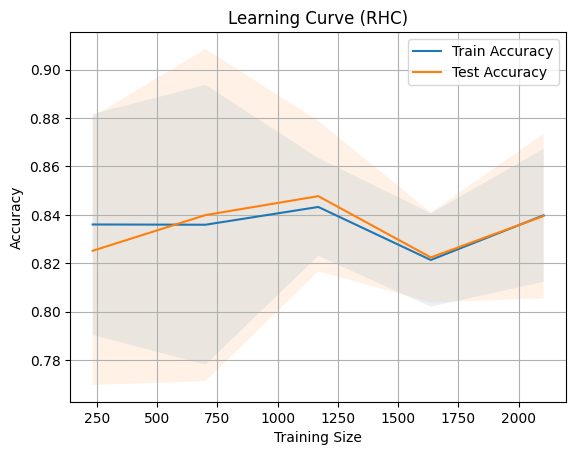

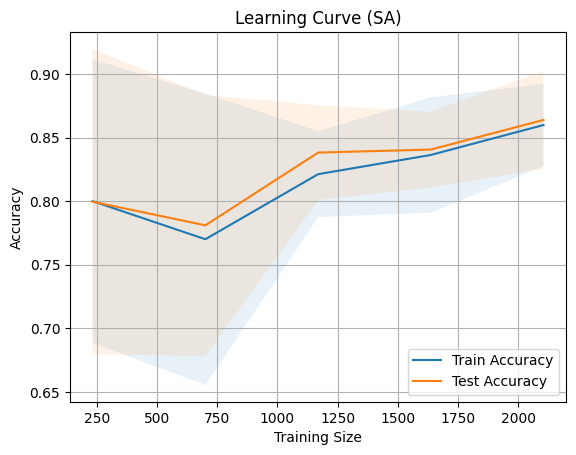

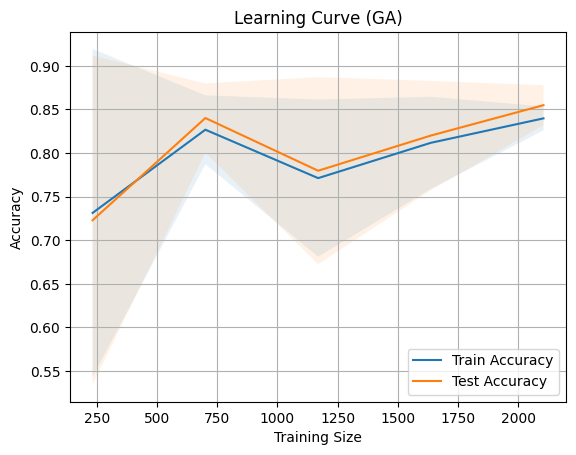

In [92]:
from sklearn.model_selection import learning_curve

def eval_algorithm(X_train, y_train, X_test, y_test, algorithm):
    # define the neural network model
    if algorithm == 'rhc':
        nn_model = mlrose.NeuralNetwork(hidden_nodes=None, activation='relu', algorithm="random_hill_climb", max_iters=2000, bias=True, is_classifier=True, learning_rate=0.001, restarts=50, early_stopping=True, clip_max=5, max_attempts=200, random_state=42)
    if algorithm == 'sa':
        nn_model = mlrose.NeuralNetwork(hidden_nodes=None, activation='relu', algorithm="simulated_annealing", max_iters=2000, bias=True, is_classifier=True, learning_rate=0.001, schedule=mlrose.ExpDecay(), early_stopping=True, clip_max=5, max_attempts=200, random_state=42)
    if algorithm == 'ga':
        nn_model = mlrose.NeuralNetwork(hidden_nodes=None, activation='relu', algorithm="genetic_alg", max_iters=2000, bias=True, is_classifier=True, learning_rate=0.001, early_stopping=True, clip_max=5, max_attempts=200, random_state=42, pop_size=200, mutation_prob=0.1)
    # fit the model
    nn_model.fit(X_train, y_train)
    # predict the values
    y_train_pred = nn_model.predict(X_train)
    y_test_pred = nn_model.predict(X_test)
    # calculate the accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    return train_accuracy, test_accuracy

# Define a function to plot learning curve
def plot_learning_curves(X_train, y_train, X_test, y_test, algorithm):
    train_sizes, train_scores, test_scores = learning_curve(estimator=mlrose.NeuralNetwork(), X=X_train, y=y_train, train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9], cv=5)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_mean, label='Train Accuracy')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.plot(train_sizes, test_mean, label='Test Accuracy')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title(f'Learning Curve ({algorithm.upper()})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot learning curve for different algorithms
algorithms = ['rhc', 'sa', 'ga']
for algo in algorithms:
    plot_learning_curves(X_train_bin, y_train, X_test_bin, y_test, algo)
